# Predicting the Condition of Tanzanian Water Systems

## Introduction

This analysis was performed with the goal of providing a way to predict the conditions of water wells in Tanzania for those who may want to use it (non profit groups, public works officials, etc)

## Business Problem

Non-profit focused on providing more opportunities for water in Tanzania. Before allocating resources to doing work, they need to find a way to predict the condition of wells in Tanzania based on certain attributes of each well and try to identify which wells need repair.

## Exploring the data 

Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, f1_score, multilabel_confusion_matrix
from sklearn.pipeline import Pipeline

Importing csvs found in `data` folder, joining them on `id`, then exploring raw dataset

In [2]:
values_df = pd.read_csv('data/training-set-values.csv')
labels_df = pd.read_csv('data/training-set-labels.csv')
df = pd.merge(labels_df, values_df, on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

Raw dataset has many columns, some of which may not have impact on analysis. Our data also has a lot of redundant columns. Create new dataframe with columns that are the most relevant to our problem and removing repetitive columns.

In [5]:
well_df = df.drop(['date_recorded', 'funder', 'installer', 'longitude', 'latitude', 'num_private',
                   'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
                   'scheme_name', 'permit', 'extraction_type', 'management', 'management_group', 'payment',
                   'water_quality', 'quantity', 'source', 'waterpoint_type', 'wpt_name', 'district_code',
                   'region_code', 'basin', 'extraction_type_group', 'source_class', 'payment_type'], 
                  axis=1)
well_df.head()

,id,status_group,amount_tsh,gps_height,population,construction_year,extraction_type_class,quality_group,quantity_group,source_type,waterpoint_type_group
0,69572,functional,6000.0,1390,109,1999,gravity,good,enough,spring,communal standpipe
1,8776,functional,0.0,1399,280,2010,gravity,good,insufficient,rainwater harvesting,communal standpipe
2,34310,functional,25.0,686,250,2009,gravity,good,enough,dam,communal standpipe
3,67743,non functional,0.0,263,58,1986,submersible,good,dry,borehole,communal standpipe
4,19728,functional,0.0,0,0,0,gravity,good,seasonal,rainwater harvesting,communal standpipe


In [6]:
well_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   gps_height             59400 non-null  int64  
 4   population             59400 non-null  int64  
 5   construction_year      59400 non-null  int64  
 6   extraction_type_class  59400 non-null  object 
 7   quality_group          59400 non-null  object 
 8   quantity_group         59400 non-null  object 
 9   source_type            59400 non-null  object 
 10  waterpoint_type_group  59400 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 5.4+ MB


In [7]:
well_df.describe()

,id,amount_tsh,gps_height,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,30500.000000,2013.000000


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


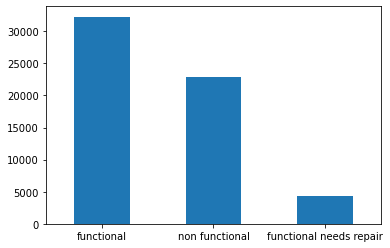

In [8]:
print(well_df['status_group'].value_counts())
well_df['status_group'].value_counts().plot(kind='bar', rot=0);

## Data Preprocessing

Splitting condensed dataset into X and y

In [9]:
y = well_df['status_group']
X = well_df.drop(columns='status_group')

One hot encoding feature columns

In [10]:
X = pd.get_dummies(X)
X.head()

,id,amount_tsh,gps_height,population,construction_year,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,...,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,6000.0,1390,109,1999,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,8776,0.0,1399,280,2010,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,34310,25.0,686,250,2009,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,67743,0.0,263,58,1986,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,19728,0.0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   id                                        59400 non-null  int64  
 1   amount_tsh                                59400 non-null  float64
 2   gps_height                                59400 non-null  int64  
 3   population                                59400 non-null  int64  
 4   construction_year                         59400 non-null  int64  
 5   extraction_type_class_gravity             59400 non-null  uint8  
 6   extraction_type_class_handpump            59400 non-null  uint8  
 7   extraction_type_class_motorpump           59400 non-null  uint8  
 8   extraction_type_class_other               59400 non-null  uint8  
 9   extraction_type_class_rope pump           59400 non-null  uint8  
 10  extraction_type_class_submersible 

## Analysis

Splitting data into training and test sets. We do this to avoid data leakage by spliting off the data into random subsets before performing any preprocessing or tuning on the data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Random Forest

In [13]:
rf_pipeline = Pipeline([('ss', StandardScaler()), ('rf', RandomForestClassifier(max_depth=5, random_state=42))])

In [14]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=5, random_state=42))])

In [15]:
cross_val_score(rf_pipeline, X, y, cv=5)

array([0.703367  , 0.7       , 0.70799663, 0.70749158, 0.71237374])

Since we are focused on identifying wells that need repair based on the information given to us in the data, we want a metric that will allow us to judge how well a model can predict true negatives. For this, we will use sklearn's `recall_score` function to measure this metric based on the three labels of our data. We will be focusing on the recall scores for non functional and functional needs repair wells; while these classes are separate, we will assume that both indicate that a well is in either immediate or eventual need for repair.

In [16]:
rf_y_pred = rf_pipeline.predict(X_test)
recall_score(y_test, rf_y_pred, average=None)

array([0.9686048 , 0.        , 0.46584065])

In [17]:
multilabel_confusion_matrix(y_test, rf_y_pred)

array([[[ 2779,  4108],
        [  250,  7713]],

       [[13774,     0],
        [ 1076,     0]],

       [[ 8717,   322],
        [ 3104,  2707]]], dtype=int64)

### Gaussian Naive Bayes

In [18]:
gnb_pipeline = Pipeline([('ss', StandardScaler()), ('gnb', GaussianNB())])

In [19]:
gnb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('gnb', GaussianNB())])

In [20]:
cross_val_score(gnb_pipeline, X, y, cv=5)

array([0.22415825, 0.29200337, 0.20505051, 0.24654882, 0.2280303 ])

In [21]:
gnb_y_pred = gnb_pipeline.predict(X_test)
recall_score(y_test, gnb_y_pred, average=None)

array([0.02511616, 0.95817844, 0.35931853])

In [22]:
multilabel_confusion_matrix(y_test, gnb_y_pred)

array([[[ 6820,    67],
        [ 7763,   200]],

       [[ 2725, 11049],
        [   45,  1031]],

       [[ 8624,   415],
        [ 3723,  2088]]], dtype=int64)

### Support Vector Machine (SVM)

In [23]:
svc_pipeline = Pipeline([('ss', StandardScaler()), ('svm', svm.SVC())])

In [24]:
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('svm', SVC())])

In [25]:
cross_val_score(svc_pipeline, X, y, cv=5)

array([0.71877104, 0.71313131, 0.72340067, 0.72112795, 0.7229798 ])

In [26]:
svc_y_pred = svc_pipeline.predict(X_test)
recall_score(y_test, svc_y_pred, average=None)

array([0.94913977, 0.00371747, 0.53278265])

In [27]:
multilabel_confusion_matrix(y_test, svc_y_pred)

array([[[ 3189,  3698],
        [  405,  7558]],

       [[13771,     3],
        [ 1072,     4]],

       [[ 8548,   491],
        [ 2715,  3096]]], dtype=int64)

## Evaluation and Conclusion

It seems that Naive Bayes performed the best in predicting whether a well was either non functional or functional but needs repair. To measure the overall performance of this model, I also use the F1 score algorithm, which scores the model based by the harmonic mean of precision and recall. 

In [28]:
f1_score(y_test, rf_y_pred, average='micro')

0.7016835016835017

In [29]:
f1_score(y_test, gnb_y_pred, average='micro')

0.2235016835016835

In [30]:
f1_score(y_test, svc_y_pred, average='micro')

0.7177104377104376

- Random Forest performs the best
- Naive Bayes is our worst model
- SVM is

### Next Steps

- Do more research on geological factors that might impact the performance and condition of water wells
- For the sake of simplicity and performance, these models do not include specific subtypes of the attributes included (e.g. extraction types). We could create a model in the future for each attribute that takes these subtypes into account for further understanding of which wells need repair.